In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n = 10
num_of_tasks = 5
cnf = 0
env = CoopEnv(n=n, num_of_tasks=num_of_tasks, cnf=cnf)
action_size = env.num_of_tasks

In [4]:
num_of_sims = 1
step_limit = 5000
steps_to_complete = np.zeros((num_of_sims, step_limit+1))

In [5]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        agentlist = {}
        for agent in range(env.n):
            agentlist[agent] = Agent(action_size) # instantiate an Agent() class for each player

        t = 0
        observations = env.reset(n=n, tasks=num_of_tasks, cnf=cnf)

        while t < step_limit:
            print(t, end='\r')

            actions = [agentlist[agent].choose_action(observations[agent]) for agent in range(env.n)]

            next_observations, rewards, termination, info = env.step(actions)

            for i in agentlist:
                agent = agentlist[i]
                agent.train(observations[i], actions[i], rewards[i], next_observations[i], termination)

            observations = next_observations
            steps_to_complete[s, t+1] = sum(rewards) + steps_to_complete[s, t]
            t +=1




In [6]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


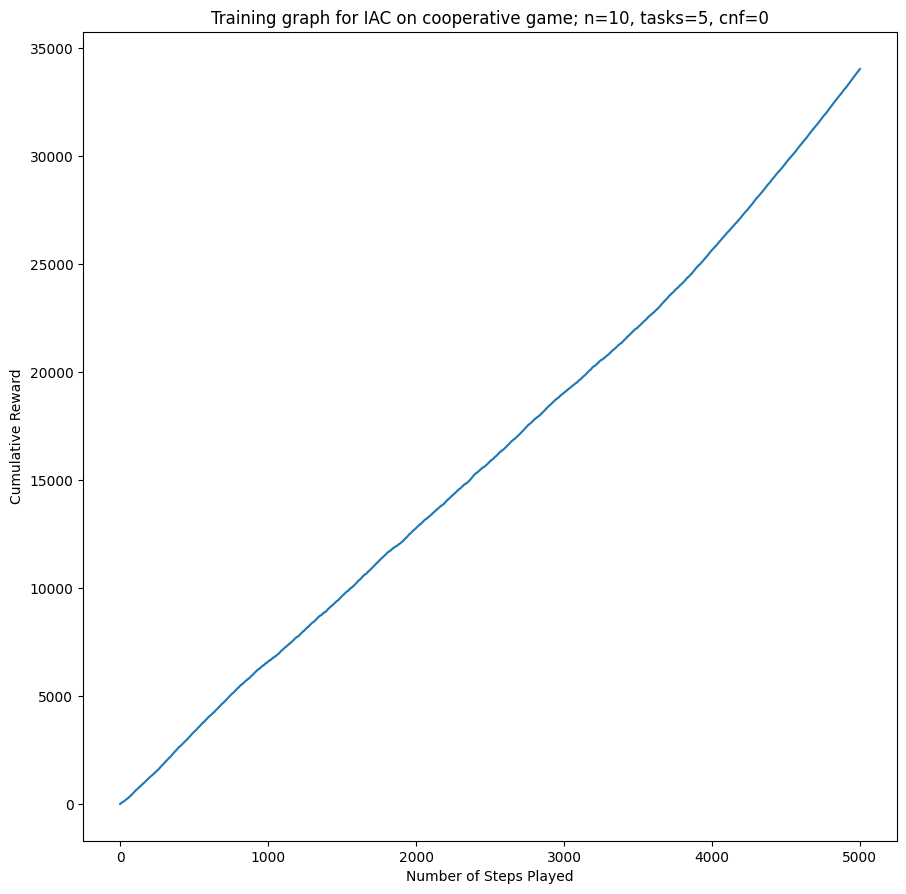

In [7]:
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Reward')
plt.title(f'Training graph for IAC on cooperative game; n={n}, tasks={num_of_tasks}, cnf={cnf}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)

In [8]:
print(f"Converged VNM stable coalition structure is: {env.CS}")

Converged VNM stable coalition structure is: [{'8', '4'}, set(), {'1', '10', '9', '7', '2', '5', '3'}, set(), {'6'}]
